1.Import the data. Analyse the dimensions of the data. Visualise the data

In [1]:
import os
import pathlib
import datetime as dt
from tqdm import tqdm
import numpy as np
import pandas as pd
import cv2 as cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import tensorflow as tf
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential, Model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

In [2]:
start = dt.datetime.now()

In [3]:
img_width, img_height = 299, 299   
batch_size = 16
data_dir = "C:\\Users\\Admin\\Desktop\\AIML\\Computer Vision"
sub_samples = 0  
split = 0.2
detourage = False     
nl_means = False     
SEED = 427

In [4]:
train_data_dir = data_dir+"/train"
val_data_dir = train_data_dir
test_data_dir = data_dir+"/test"
labels = sorted(os.listdir(train_data_dir))
print(labels)
data_dir

['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


'C:\\Users\\Admin\\Desktop\\AIML\\Computer Vision'

In [5]:
data = []
for category_id, category in enumerate(labels):
    for file in os.listdir(os.path.join(train_data_dir, category)):
        data.append(['{}/{}/{}'.format(train_data_dir, category, file), category_id, category])
data = pd.DataFrame(data, columns=['filepath', 'category_id', 'category'])
display(data.head(2))
print(data.shape)

,filepath,category_id,category
0,C:\Users\Admin\Desktop\AIML\Computer Vision/tr...,0,Black-grass
1,C:\Users\Admin\Desktop\AIML\Computer Vision/tr...,0,Black-grass


(4767, 3)


array([[<AxesSubplot:title={'center':'category_id'}>]], dtype=object)

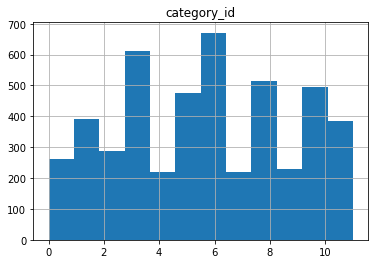

In [6]:
data.hist(column='category_id', bins=12)

In [7]:
test = []
for file in sorted(os.listdir(test_data_dir)):
    test.append(['{}/{}'.format(test_data_dir, file), file])
test = pd.DataFrame(test, columns=['filepath', 'file'])
display(test.head(2))
print(test.shape)

,filepath,file
0,C:\Users\Admin\Desktop\AIML\Computer Vision/te...,Predict.png


(1, 2)


In [8]:
if sub_samples > 0:
    data = pd.concat([data[data['category'] == c][:sub_samples] for c in labels])
    data = data.sample(frac=1)
    data.index = np.arange(len(data))
    display(data.head(2))
    print(data.shape)

In [9]:
np.random.seed(seed=SEED)
rnd = np.random.random(len(data))
train_idx = rnd > split
valid_idx = rnd <= split
train_y = data.loc[train_idx, 'category_id'].values
val_y = data.loc[valid_idx, 'category_id'].values
df_train_x = data.loc[train_idx, 'filepath'].values
df_val_x = data.loc[valid_idx, 'filepath'].values
print("{} images for train".format(len(df_train_x)))
print("{} images for validation".format(len(df_val_x)))

3814 images for train
953 images for validation


In [10]:
def create_mask_for_plant(image):
    sensitivity=35    # Note: testé, c'est la meilleure valeur 
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])
    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return mask
def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output
def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

In [11]:
def preprocessing_cnn(img, mask_grass=False, nl_means=False):
    if mask_grass:
        img_segmented = segment_plant(img)
        img = sharpen_image(img_segmented)
    if nl_means:
        img = cv2.fastNlMeansDenoisingColored(
            src=img.astype(np.uint8),
            dst=None,
            h=10,
            hColor=10,
            templateWindowSize=7,
            searchWindowSize=21)
    return img
def show_image_preprocc(image):
    image_mask = create_mask_for_plant(image)
    image_segmented = segment_plant(image)
    image_sharpen = sharpen_image(image_segmented)
    image_nlmeans = preprocessing_cnn(image_sharpen, nl_means=True)
    fig, axs = plt.subplots(1, 5, figsize=(20, 20))
    axs[0].imshow(image)
    axs[1].imshow(image_mask)
    axs[2].imshow(image_segmented)
    axs[3].imshow(image_sharpen)
    axs[4].imshow(image_nlmeans)

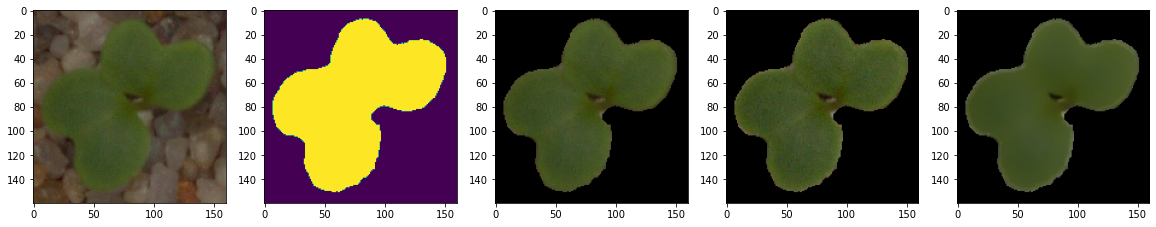

In [12]:
class_indix = 1
img_indix = 1 
list_files_cat = data['filepath'][data['category_id']==class_indix].reset_index(drop=True)
image_path = list_files_cat[img_indix]
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
show_image_preprocc(image)

2.Design, train tune and test

In [13]:
train_x = np.zeros((len(df_train_x), img_width, img_height, 3), dtype='float32')
for i, file in tqdm(enumerate(df_train_x)):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_width, img_height))
    img = preprocessing_cnn(img, mask_grass=detourage, nl_means=nl_means)
    img = tf.keras.utils.img_to_array(img)
    x = preprocess_input(np.expand_dims(img, axis=0))
    train_x[i] = x
print('Train Images shape: {} size: {:,}'.format(train_x.shape, train_x.size))

3814it [01:47, 35.57it/s]


Train Images shape: (3814, 299, 299, 3) size: 1,022,926,242


In [14]:
val_x = np.zeros((len(df_val_x), img_width, img_height, 3), dtype='float32')
for i, file in tqdm(enumerate(df_val_x)):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_width, img_height))
    img = preprocessing_cnn(img, mask_grass=detourage, nl_means=nl_means)
    img = tf.keras.utils.img_to_array(img)
    x = preprocess_input(np.expand_dims(img, axis=0))
    val_x[i] = x
print('Validation Images shape: {} size: {:,}'.format(val_x.shape, val_x.size))

953it [00:31, 30.10it/s]

Validation Images shape: (953, 299, 299, 3) size: 255,597,459


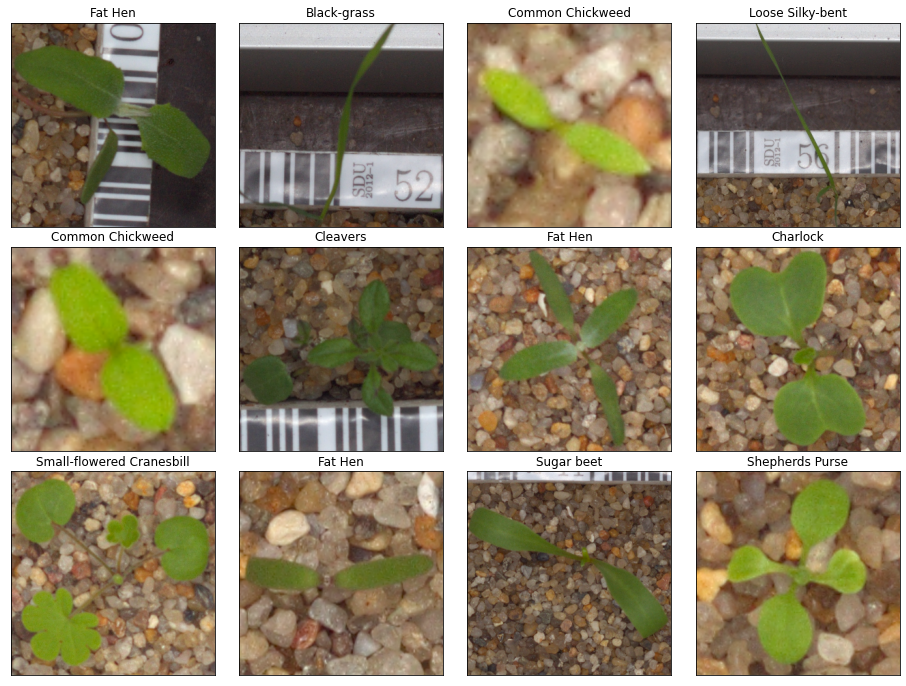

In [15]:
y_true_s = [labels[y] for y in train_y]

sample_idxs = np.arange(len(train_x))
np.random.shuffle(sample_idxs)
picks = sample_idxs[:12]

fig = plt.figure(1, figsize=(16,12))
for i, r in enumerate(picks):
    plt.subplot(3,4,i+1)
    plt.subplots_adjust(hspace = 0.1, wspace = 0.1)
    plt.imshow(tf.keras.utils.array_to_img(train_x[r]))
    plt.title('{}'.format(y_true_s[r]))
    plt.xticks([]) , plt.yticks([])
    
plt.show()

Xception CNN

In [16]:
transfer_model = tf.keras.applications.xception.Xception(include_top=False, weights='imagenet', pooling='avg', input_shape=(img_height, img_width, 3))
INPUTOK = True
train_x_bf = transfer_model.predict(train_x, batch_size=batch_size, verbose=1)
val_x_bf = transfer_model.predict(val_x, batch_size=batch_size, verbose=1)
print('Xception train bottleneck features shape: {} size: {:,}'.format(train_x_bf.shape, train_x_bf.size))
print('Xception valid bottleneck features shape: {} size: {:,}'.format(val_x_bf.shape, val_x_bf.size))

60/60 [==============================] - 318s 5s/step
Xception train bottleneck features shape: (3814, 2048) size: 7,811,072
Xception valid bottleneck features shape: (953, 2048) size: 1,951,744


In [17]:
def plot_acc_loss(history, metrics = None):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(loss))

    num_subplot = 2
    if metrics is not None:
        num_subplot += len(metrics)

    plt.figure(figsize=(8+2*num_subplot, 8))
    plt.subplot(1, num_subplot, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    if val_acc is not None:
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, num_subplot, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    if val_loss is not None:
        plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    if metrics is not None:
        for i, met in enumerate(metrics):
            m = history.history[met]
            val_m = history.history['val_'+met]
            plt.subplot(1, num_subplot, 3+i)
            plt.plot(epochs_range, m, label='Training '+met)
            if val_m is not None:
                plt.plot(epochs_range, val_m, label='Validation '+met)
            plt.legend()
            plt.title('Training and Validation '+met)
        
    plt.show()

Best AIML image classifier model 

In [18]:
classifier = {}

def train_predict_score(model, train_x, train_y, val_x, val_y):
    t0 = dt.datetime.now()
    model.fit(train_x, train_y)
    val_preds = model.predict(val_x)
    val_probs = model.predict_proba(val_x)
    score = accuracy_score(val_y, val_preds)
    t = dt.datetime.now()-t0
    print('Train/Predict/Evaluate time: {} sec'.format(t.seconds))
    return val_preds, val_probs, score, t

Random Forest Classifier

In [19]:
if INPUTOK:
    rfc = RandomForestClassifier()
    val_pred, val_prob, score, t = train_predict_score(rfc, train_x_bf, train_y, val_x_bf, val_y)
    print('Validation Xception+RandomForestClassifier Accuracy {}'.format(score))

    classifier['rfc'] = (rfc, val_pred, val_prob, score, t)

Train/Predict/Evaluate time: 28 sec
Validation Xception+RandomForestClassifier Accuracy 0.720881427072403


Logistic Regression

In [20]:
if INPUTOK:
    logreg = LogisticRegression(multi_class='multinomial', solver='sag', random_state=SEED, max_iter=200)
    val_pred, val_prob, score, t = train_predict_score(logreg, train_x_bf, train_y, val_x_bf, val_y)
    print('Validation Accuracy [Xception+LogisticRegression]: {}'.format(score))

    classifier['logreg'] = (logreg, val_pred, val_prob, score, t)

Train/Predict/Evaluate time: 229 sec
Validation Accuracy [Xception+LogisticRegression]: 0.8835257082896117


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Fully connected layer

Epoch 1/30
3814/3814 [==============================] - 63s 13ms/step - loss: 1.9762 - accuracy: 0.3804 - val_loss: 1.4679 - val_accuracy: 0.5929
Epoch 2/30
3814/3814 [==============================] - 51s 13ms/step - loss: 1.2764 - accuracy: 0.6091 - val_loss: 1.0369 - val_accuracy: 0.7093
Epoch 3/30
3814/3814 [==============================] - 50s 13ms/step - loss: 0.9905 - accuracy: 0.6904 - val_loss: 0.8371 - val_accuracy: 0.7681
Epoch 4/30
3814/3814 [==============================] - 51s 13ms/step - loss: 0.8226 - accuracy: 0.7509 - val_loss: 0.7153 - val_accuracy: 0.7912
Epoch 5/30
3814/3814 [==============================] - 51s 13ms/step - loss: 0.7012 - accuracy: 0.7790 - val_loss: 0.6228 - val_accuracy: 0.8227
Epoch 6/30
3814/3814 [==============================] - 50s 13ms/step - loss: 0.6184 - accuracy: 0.8070 - val_loss: 0.5750 - val_accuracy: 0.8185
Epoch 7/30
3814/3814 [==============================] - 50s 13ms/step - loss: 0.5464 - accuracy: 0.8317 - val_loss: 0.5304 -

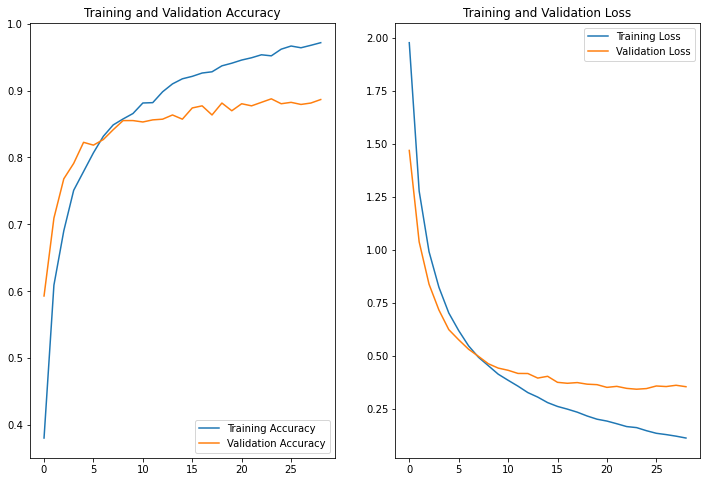

Validation Xception+Fully-connected Accuracy 0.8866736621196223


In [21]:
if True:
    fully_connected = Sequential([
        Flatten(),
        Dense(100, activation='relu'),
        tf.keras.layers.BatchNormalization(trainable = False,axis=1),
        Dropout(0.2),
        Dense(50, activation='relu'),
        Dense(len(labels), activation='softmax')
    ])
    optimizer = tf.keras.optimizers.Nadam(learning_rate=0.00004, beta_1=0.9, beta_2=0.999)
    fully_connected.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    t0 = dt.datetime.now()
    history = fully_connected.fit(
        x = train_x_bf,
        y = train_y,
        steps_per_epoch= train_x.shape[0],
        epochs=30,
        validation_data=(val_x_bf, val_y),
        validation_steps=val_x_bf.shape[0],
        callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
    )

    fc_valid_preds_res = fully_connected.predict(val_x_bf)
    fc_valid_preds = np.argmax(fc_valid_preds_res, axis=1)
    fc_valid_probs = np.max(fc_valid_preds_res, axis=1)
    fc_score = accuracy_score(val_y, fc_valid_preds)
    t = dt.datetime.now()-t0
    print('Train/Predict/Evaluate time: {} sec'.format(t.seconds))
    plot_acc_loss(history)
    print('Validation Xception+Fully-connected Accuracy {}'.format(fc_score))

    classifier['fc'] = (fully_connected, fc_valid_preds, fc_valid_probs, fc_score, t)

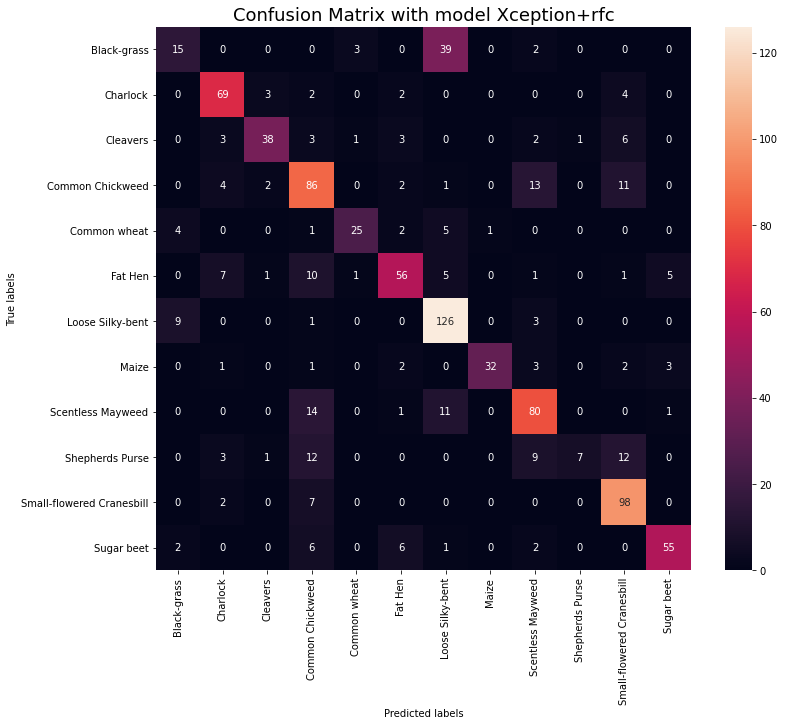

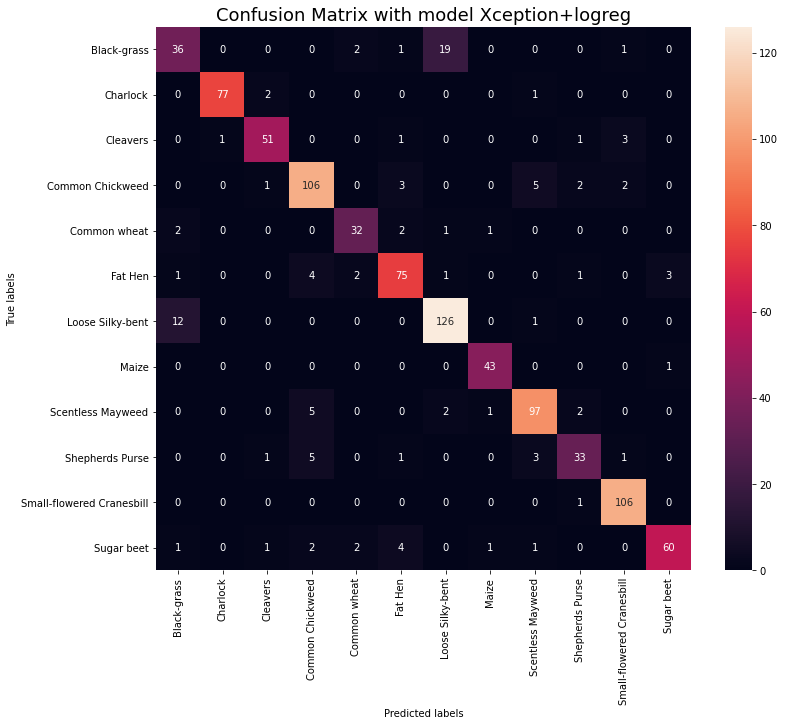

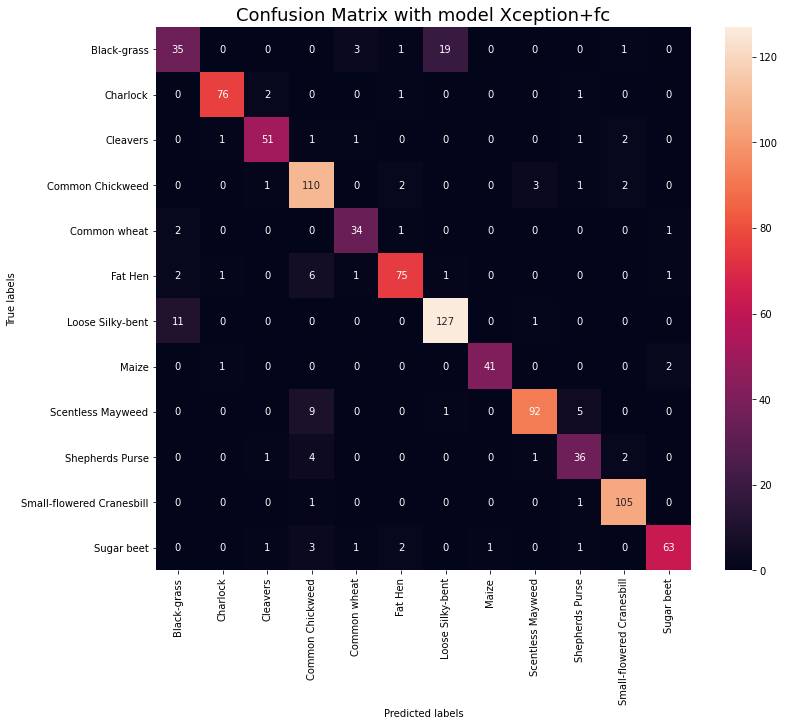

In [22]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

for key in classifier:
    y_pred = classifier[key][1]
    cf_matrix = confusion_matrix(val_y, y_pred, labels=range(len(labels)))
    fig = plt.figure(figsize=(12,10))
    ax = sns.heatmap(cf_matrix, annot=True, fmt='d')
    ax.set_xlabel("Predicted labels")
    ax.set_ylabel("True labels")
    ax.xaxis.set_ticklabels(labels, rotation='vertical')
    ax.yaxis.set_ticklabels(labels, rotation='horizontal')
    plt.title("Confusion Matrix with model Xception+"+key, fontsize=18)
    plt.show()

In [23]:
best_score = 0.0
best_classifier_key = ''
print("classifier \t score \t\t time")
for key in classifier:
    score = classifier[key][3]
    print("{}\t{}\t{}".format(key, score, classifier[key][4]))
    if score > best_score:
        best_score = score
        best_classifier_key = key        
print("\nBest classifier: {}  - score: {}".format(best_classifier_key, best_score))

classifier 	 score 		 time
rfc	0.720881427072403	0:00:28.110464
logreg	0.8835257082896117	0:03:49.826275
fc	0.8866736621196223	0:25:41.952841

Best classifier: fc  - score: 0.8866736621196223


Fully connected layer has got best score for the plant image classification data

5.The best trained image classifier model to predict the class

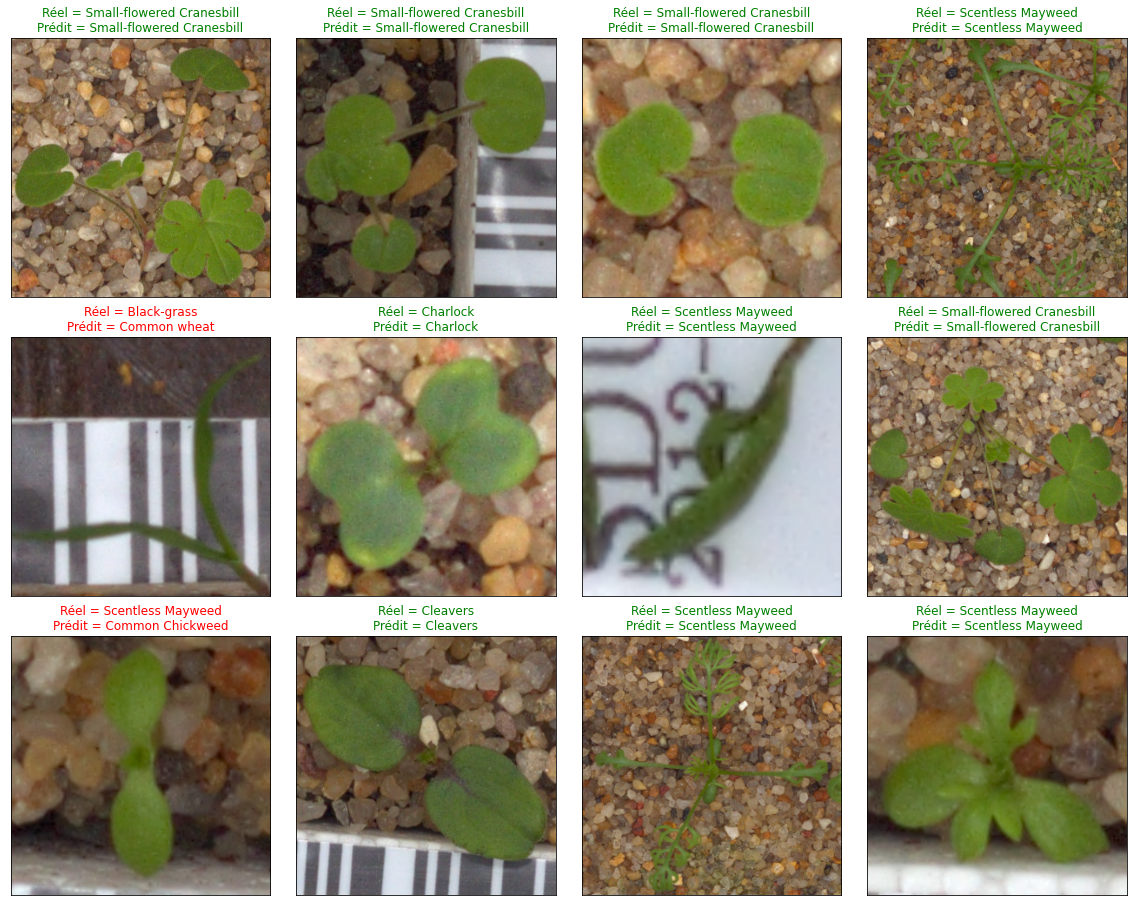

In [24]:
y_true_s = [labels[x] for x in val_y]
y_pred_s = [labels[x] for x in classifier[best_classifier_key][1]]

fig = plt.figure(1, figsize=(20,16))
test_idxs = np.arange(len(val_x))
np.random.shuffle(test_idxs)
picks = test_idxs[:12]
for i, r in enumerate(picks):
    batch_r = r // batch_size
    idx_r = r % batch_size
    plt.subplot(3,4,i+1)
    plt.subplots_adjust(hspace = 0.1, wspace = 0.1)
    plt.imshow(tf.keras.utils.array_to_img(val_x[r]))
    plt.title('Réel = {}\nPrédit = {}'.format(y_true_s[r], y_pred_s[r]), color= 'green' if y_true_s[r] == y_pred_s[r] else 'red')
    plt.xticks([]) , plt.yticks([])
    
plt.show()

prediction(rfc): Maize  (74.0)
prediction(logreg): Maize  (99.88445043563843)
prediction(fc): Maize  (99.9180257320404)


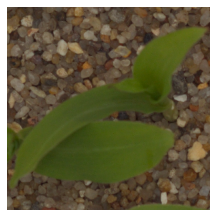

In [25]:
image_path = os.path.join(data_dir,'test/Predict.png')
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (img_width, img_height))
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(image)
plt.axis("off")

if detourage or nl_means:
    image = preprocessing_cnn(image, mask_grass=detourage, nl_means=nl_means)
    plt.subplot(122)
    plt.imshow(image)
    plt.axis("off")

img_array = tf.keras.utils.img_to_array(image)
img_array = preprocess_input(tf.expand_dims(img_array, 0))
img_bf = transfer_model.predict(img_array)

for key in classifier:
    prediction = classifier[key][0].predict(img_bf)
    if key == 'fc':
        prediction_fc = np.argmax(prediction, axis=1)
        prediction_proba_fc = np.max(prediction, axis=1)
        print("prediction({}): {}  ({})".format(key, labels[prediction_fc[0]], 100*prediction_proba_fc[0]))
    else:
        prediction_proba = classifier[key][0].predict_proba(img_bf)
        print("prediction({}): {}  ({})".format(key, labels[prediction[0]], 100*np.max(prediction_proba[0])))

In [26]:
test_x = np.zeros((len(test), img_width, img_height, 3), dtype='float32')
for i, file in tqdm(enumerate(test['filepath'])):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_width, img_height))
    img = preprocessing_cnn(img, mask_grass=detourage, nl_means=nl_means)
    img = tf.keras.utils.img_to_array(img)
    x = preprocess_input(np.expand_dims(img, axis=0))
    test_x[i] = x
print('Test Images shape: {} size: {:,}'.format(test_x.shape, test_x.size))

1it [00:00, 29.96it/s]

Test Images shape: (1, 299, 299, 3) size: 268,203


In [27]:
test_x_bf = transfer_model.predict(test_x, batch_size=batch_size, verbose=1)
print('Xception test bottleneck features shape: {} size: {:,}'.format(test_x_bf.shape, test_x_bf.size))
test_preds = classifier[best_classifier_key][0].predict(test_x_bf)

1/1 [==============================] - 28s 28s/step
Xception test bottleneck features shape: (1, 2048) size: 2,048


In [28]:
if best_classifier_key == 'fc':
    test_preds = np.argmax(test_preds, axis=1)

In [29]:
test['category_id'] = test_preds
test['species'] = [labels[c] for c in test_preds]
test[['file', 'species']].to_csv('submission.csv', index=False)

In [30]:
print("Total Notebook time: {} sec".format((dt.datetime.now()-start).seconds))

Total Notebook time: 5543 sec
